# Classification Tasks using Convolutional Neural Network, MobileNet-V3
This is tutorial for Kaggle Competition, "Digit Recognizer"

The main purpose of this work is to verify implemented MobileNetV3.

In [2]:
!pip install torch
!pip install torchvision
!pip install pytorch-model-summary

In [120]:
import torch
import torch.nn as nn
import os
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import pytorch_model_summary
import time
import torchvision

In [122]:
if 'google.colab' in str(get_ipython()):
    print('Running on Colab')
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataDir = Path('/content/gdrive/My Drive', 'dataset')
    checkpointDir = Path('/content/gdrive/My Drive', 'checkpoints')
else:
    dataDir = Path('.', 'dataset')
    checkpointDir = Path('.', 'checkpoints', 'fam')

dataDir.mkdir(exist_ok=True, parents=True)
checkpointDir.mkdir(exist_ok=True, parents=True)

fileDir = Path(dataDir, 'mnist')
qFileName = {}
qFiles = os.listdir(fileDir)
for fName in qFiles:
    fNameTmp = fName.lower()
    if fNameTmp.find('train') != -1:
        qFileName['train'] = fName
    elif fNameTmp.find('test') != -1:
        qFileName['test'] = fName

torch.random.manual_seed(42)
np.random.seed(42)

Running on Colab
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [140]:
def convBlock(inp, oup, kernel, stride, padding, bias=True, groups=1):
    return nn.Sequential(
      nn.Conv2d(inp, oup, kernel, stride, padding, bias=bias, groups=groups),
      nn.BatchNorm2d(oup),
    )

class SqueezeExciteLayer(nn.Module):
    def __init__(self, outDim, reductionNum):
        super(SqueezeExciteLayer, self).__init__()
        hiddenNum = int(outDim / reductionNum)
        self.fc1 = nn.Linear(outDim, hiddenNum)
        self.fc2 = nn.Linear(hiddenNum, outDim)
        self.outDim = outDim

    def forward(self, x):
        squeeze = x.mean(3).mean(2)
        excitation = F.relu(self.fc1(squeeze))
        excitation = torch.sigmoid(self.fc2(excitation))
        excitation = torch.reshape(excitation, [-1, self.outDim, 1, 1])
        return x * excitation

class InvertedResidualv3(nn.Module):
    def __init__(self, inp, oup, kernel, stride, padding, bias=True, expandRatio=6, reductionNum=4):
        super(InvertedResidualv3, self).__init__()
        self.stride = stride
        self.inp = inp
        self.oup = oup
        hiddenDim = int(inp * expandRatio)
        self.use_res_connect = self.stride == 1 and inp == oup
        layers = []        
        if expandRatio == 1:
            # depthwise
            layers.append(convBlock(inp, hiddenDim, kernel, stride, padding, groups=hiddenDim, bias=bias))
            layers.append(nn.LeakyReLU())
            # pointwise
            layers.append(convBlock(hiddenDim, oup, 1, 1, padding, bias=bias))
        else:
            # pointwise
            layers.append(convBlock(inp, hiddenDim, 1, 1, padding, bias=bias))
            layers.append(nn.LeakyReLU())
            # depthwise
            layers.append(convBlock(hiddenDim, hiddenDim, kernel, self.stride, 1, groups=hiddenDim, bias=bias))
            layers.append(nn.LeakyReLU())
            # squeeze&excite layer
            layers.append(SqueezeExciteLayer(hiddenDim, reductionNum))
            # pointwise
            layers.append(convBlock(hiddenDim, oup, 1, 1, padding, bias=bias))
        self.conv = nn.Sequential(*layers)
    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV3(nn.Module):
    def __init__(self, inDim=2, outDim=19):
        super(MobileNetV3, self).__init__()
        block = InvertedResidualv3
        bias = False
        kernel = (3,3)
        inputChannel = 12
        expandRatio = 6
        padding='valid'
        invertedResidualSetting = [
          # t, c, n, s
          [6, 12, 2, 2],
          [6, 24, 1, 2],
        ]

        self.features = [convBlock(inDim, inputChannel, kernel, 1, padding, bias=bias)]
        for t, c, n, s in invertedResidualSetting:
            outputChannel = c
            for i in range(n):
                if i == 0:
                    self.features.append(block(inputChannel, outputChannel, kernel, s, padding, bias, expandRatio=t))
                else:
                    self.features.append(block(inputChannel, outputChannel, kernel, 1, padding, bias, expandRatio=t))
                inputChannel = outputChannel
        self.features = nn.Sequential(*self.features)
        self.conv1 = nn.Sequential(
            convBlock(inputChannel, inputChannel * expandRatio, 1, 1, padding),
            nn.LeakyReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(inputChannel * expandRatio, inputChannel, 1, 1, padding),
            nn.LeakyReLU()
        )
        self.fc1 = nn.Linear(inputChannel, outDim)
        self._initialize_weights()
    
    def forward(self, x):
        x = self.features(x)
        x = self.conv1(x)
        x = x.mean(3, keepdim=True).mean(2, keepdim=True)
        x = self.conv2(x)
        return F.softmax(self.fc1(torch.squeeze(x)), dim=1)
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.t(m.weight, gain=0.1)
                nn.init.normal_(m.weight, std=0.1)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight)

In [151]:
class DigitDataset(Dataset):
    def __init__(self, csv_data, transform, phase='training'):
        self.csv_data = csv_data
        self.transform = transform
        raw_tensor = torch.tensor(csv_data)
        self.phase = phase
        if self.phase == 'training':
            self.data, self.labels = raw_tensor[:, 1:].view(-1, 28, 28), raw_tensor[:, 0]
        if self.phase == 'testing':
            # test dataset does not have label, only digit data
            self.data = raw_tensor.view(-1, 28, 28)
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.phase == 'training':
            return self.transform(self.data[idx]), self.labels[idx]
        if self.phase == 'testing':
            # idx+1 is not used, but it is real label of the test dataset
            return self.transform(self.data[idx]), (idx+1)
        
def training(model, datasets, datasets_size, optimizer, scheduler, epochs=10):
    # Conduct train and valid per a epoch
    phases = ['train', 'valid']
    
    best_valid_accuracy = -1.0
    
    training_loss = []
    validation_loss = []
        
    for epoch in range(epochs):                
        print(f'-------------- Epoch {epoch+1} --------------')        
        
        for phase in phases:
            epoch_begin = time.time()
            epoch_accuracy = 0.0
            epoch_losses = 0.0
            
            if phase == 'train':
                model.train()
                
            if phase == 'valid':
                model.eval()
                
            for data in datasets[phase]:
                # Init weights for each batch dataset
                if phase == 'train':
                    optimizer.zero_grad()
                    
                inputs, labels = data
                # to use nll_loss, labels should be LongTensor
                labels = labels.type(torch.LongTensor)
                if torch.cuda.is_available():
                    inputs, labels = inputs.cuda(), labels.cuda()
                
                output = model(inputs)
                _, preds = torch.max(output, 1)
                loss = F.nll_loss(output, labels)
                
                # add .detach() because of the out of memory issue. (grow computational graph)
                epoch_losses += loss.sum().detach()
                epoch_accuracy += torch.sum(preds == labels).detach().item()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                        
            epoch_losses = epoch_losses / datasets_size[phase]
            epoch_accuracy = 100. * epoch_accuracy / datasets_size[phase]
            print(f'{phase} Epoch Losses : {epoch_losses:.5f} :: Accuracy : {epoch_accuracy:.5f} :: Time : {(time.time() - epoch_begin):.4f}s')
            
            if phase == 'train':
                training_loss.append(epoch_losses)
            if phase == 'valid':
                if best_valid_accuracy < epoch_accuracy:
                    best_valid_accuracy = epoch_accuracy
                    torch.save(model.state_dict(), 'final_model.pth')
                validation_loss.append(epoch_losses)
        
        scheduler.step()
    return training_loss, validation_loss

def testing(model, dataset):
    result = []
    if torch.cuda.is_available():
            model.cuda()
    for data in dataset:
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        output = model(inputs)
        _, preds = torch.max(output, 1)
        # testing data is sequential, so label is unnecessary thing
        result += [int(element) for element in preds.tolist()]
    return result

In [142]:
epochs = 20
batch_size = 64
learning_rate = 1e-4
inputDim = 1
outDim = 10

In [143]:
model = MobileNetV3(inputDim, outDim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50)

dummy_input = torch.zeros(batch_size, inputDim, 28, 28)
print(pytorch_model_summary.summary(model, dummy_input))

-----------------------------------------------------------------------------
           Layer (type)         Output Shape         Param #     Tr. Param #
               Conv2d-1     [64, 12, 26, 26]             108             108
          BatchNorm2d-2     [64, 12, 26, 26]              24              24
   InvertedResidualv3-3     [64, 12, 13, 13]           5,370           5,370
   InvertedResidualv3-4     [64, 12, 13, 13]           5,370           5,370
   InvertedResidualv3-5       [64, 24, 7, 7]           6,258           6,258
               Conv2d-6      [64, 144, 7, 7]           3,600           3,600
          BatchNorm2d-7      [64, 144, 7, 7]             288             288
            LeakyReLU-8      [64, 144, 7, 7]               0               0
               Conv2d-9       [64, 24, 1, 1]           3,480           3,480
           LeakyReLU-10       [64, 24, 1, 1]               0               0
              Linear-11             [64, 10]             250             25

In [144]:
if torch.cuda.is_available():
    model = model.cuda()

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((28, 28)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])
])

# Load data
valid_fraction = 0.1

train_file = pd.read_csv(Path(fileDir, qFileName['train']))
# convert dataframe of pandas into numpy array
train_file = train_file.to_numpy().astype('uint8')

boundary = int(len(train_file) * (1 - valid_fraction))

train_data = DigitDataset(train_file[:boundary], transforms, phase='training')
valid_data = DigitDataset(train_file[boundary:], transforms, phase='training')

train_data_loader = DataLoader(
    train_data,
    batch_size = 64,
    shuffle = True,
    num_workers = 3
)

valid_data_loader = DataLoader(
    valid_data,
    batch_size = 64,
    shuffle = True,
    num_workers = 3
)

datasets = {'train' : train_data_loader, 'valid' : valid_data_loader}
datasets_size = {'train' : len(train_data_loader.dataset), 'valid' : len(valid_data_loader.dataset)}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [145]:
train_loss, valid_loss = training(model, datasets, datasets_size, optimizer, scheduler, epochs=epochs)

-------------- Epoch 0 --------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Epoch Losses : -0.00469 :: Accuracy : 32.27249 :: Time : 133.3693s
valid Epoch Losses : -0.00673 :: Accuracy : 46.02381 :: Time : 4.9538s
-------------- Epoch 1 --------------
train Epoch Losses : -0.00825 :: Accuracy : 55.50794 :: Time : 139.5313s
valid Epoch Losses : -0.00961 :: Accuracy : 62.90476 :: Time : 5.1903s
-------------- Epoch 2 --------------
train Epoch Losses : -0.00965 :: Accuracy : 63.29630 :: Time : 138.5436s
valid Epoch Losses : -0.01000 :: Accuracy : 65.16667 :: Time : 4.9324s
-------------- Epoch 3 --------------
train Epoch Losses : -0.00996 :: Accuracy : 64.98942 :: Time : 138.5485s
valid Epoch Losses : -0.01024 :: Accuracy : 66.23810 :: Time : 5.0353s
-------------- Epoch 4 --------------
train Epoch Losses : -0.01060 :: Accuracy : 69.83069 :: Time : 139.9407s
valid Epoch Losses : -0.01120 :: Accuracy : 73.45238 :: Time : 5.0024s
-------------- Epoch 5 --------------
train Epoch Losses : -0.01131 :: Accuracy : 74.31746 :: Time : 139.1041s
valid Epoch Losse

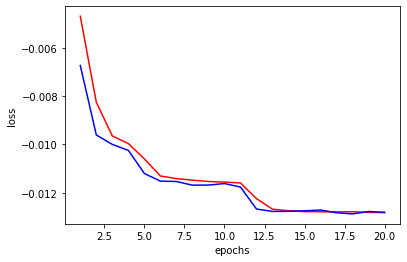

In [146]:
# Draw loss graph for training
epoch_x = range(1, epochs + 1)
plt.plot(epoch_x, train_loss, 'r', epoch_x, valid_loss, 'b')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [147]:
# Load test dataset
test_file = pd.read_csv(Path(fileDir, qFileName['test']))
test_file = test_file.to_numpy().astype('uint8')

test_data = DigitDataset(test_file, transforms, phase='testing')

test_data_loader = DataLoader(
    test_data,
    batch_size = 16,
    num_workers = 3
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [152]:
# Load best model
model = MobileNetV3(inputDim, outDim)
model.load_state_dict(torch.load('final_model.pth'))

if torch.cuda.is_available():
    model = model.cuda()

# Test the model
result = testing(model, test_data_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [153]:
# Export result as csv file in form of Kaggle
submission = pd.DataFrame({
    'ImageId' : range(1, len(result) + 1),
    'Label' : result
},columns=['ImageId', 'Label'])
submission.to_csv('submission.csv', index=False)